In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_columns', None) #int or None = all

In [3]:
data = pd.read_csv('/Users/juliankopp1/Documents/GitHub/Chicago/data/chicago_crashes_cleaned_32.csv')

In [4]:
data.head()

,Unnamed: 0,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ROADWAY_SURFACE_COND,...,STREET_NAME,LATITUDE,LONGITUDE,CRASH_WEEKDAY,CRASH_HOUR,CRASH_Month,grid_32,grid_48,grid_67,grid_96
0,3,2017-06-30 16:00:00,35,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,DRY,...,CICERO AVE,41.741804,-87.740954,4,16,6,"(10.0, 8.0)","(15.0, 12.0)","(21.0, 17.0)","(30.0, 25.0)"
1,4,2019-03-21 22:50:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,NOT DIVIDED,DRY,...,CICERO AVE,41.741804,-87.740954,3,22,3,"(10.0, 8.0)","(15.0, 12.0)","(21.0, 17.0)","(30.0, 25.0)"
2,5,2018-03-26 14:23:00,35,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,NOT DIVIDED,DRY,...,AVONDALE AVE,41.953647,-87.732082,0,14,3,"(11.0, 27.0)","(16.0, 39.0)","(23.0, 55.0)","(33.0, 79.0)"
3,6,2018-08-30 17:45:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,DRY,...,DIVISION ST,41.903825,-87.643286,3,17,8,"(20.0, 22.0)","(29.0, 33.0)","(41.0, 46.0)","(59.0, 66.0)"
4,7,2019-06-11 08:40:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,DIVIDED - W/MEDIAN BARRIER,DRY,...,GARFIELD BLVD,41.794779,-87.623828,1,8,6,"(22.0, 13.0)","(32.0, 19.0)","(45.0, 27.0)","(65.0, 38.0)"


### How granular should the grid be?

In [45]:
def compare_grid(grid, exp_qt_cells, ax, row, col):
    grid_version = data.groupby(['{}'.format(grid)]).size()
    grid_version.mean()

    empty_cells_perc = ((exp_qt_cells - len(grid_version))/ exp_qt_cells)*100

    print("Metrics for {}:".format(grid))
    print("Empty cells: {:.2f}%, {} absolute.".format(empty_cells_perc, exp_qt_cells - len(grid_version)))
    print("Mean Accidents: {:.2f}, with std: {:.2f} and median: {}"\
          .format(grid_version.mean(), grid_version.std(), grid_version.median()))
    print("")
    grid_version.plot(kind='hist', bins=50,\
                      title='Number of acidents per cell in version:{}'.format(grid),\
                      ax=ax[row,col], figsize=(10,7))

Metrics for grid_32:
Empty cells: 44.68%, 500 absolute.
Mean Accidents: 715.10, with std: 697.53 and median: 627.0

Metrics for grid_48:
Empty cells: 46.41%, 1060 absolute.
Mean Accidents: 361.64, with std: 360.99 and median: 289.0

Metrics for grid_67:
Empty cells: 48.64%, 2177 absolute.
Mean Accidents: 192.54, with std: 208.04 and median: 140.0

Metrics for grid_96:
Empty cells: 51.22%, 4679 absolute.
Mean Accidents: 99.34, with std: 121.20 and median: 62.0



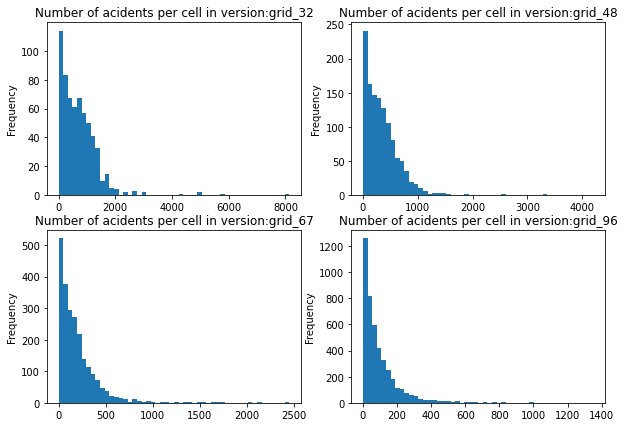

In [46]:
f, ax = plt.subplots(2,2)

compare_grid('grid_32', 1119, ax, 0, 0)
compare_grid('grid_48', 2284, ax, 0, 1)
compare_grid('grid_67', 4476, ax, 1, 0)
compare_grid('grid_96', 9135, ax, 1, 1)

#### Analysing results
With 33 cells we still have a high number of empty cells because the bounding box also spanns non-chicago areas (lake and outside city bounds).

The increase of empty cells is marginal when increasing the number of cells. Increasing the number of cells mean a single cell will get smaller and could then potentially be rendered outside the city bounds. 

Result is that data is not sparse and we can assume that most cells have enough data to predict the future from historical observations. 
Due to some extreme outlers we also check the median which is robust against outliers. 

We would like to choose the grid version with most cells and therefore highest granularity of an 'risk area' (which is one cell). However the granularity needs to be balanced by data sparsity. We decide to proceed with grid 67 as it has a median of 140 accidents per cell which we judge good enough.
Grid 96 seems okayish as well but we do not want to take an extreme first decision. If further analysis shows that the model could work with even less data we will come back an quickly rerun the process for Grid 96. 

Grid 67 delivers us cells of 618m (S to N) x 403m (E to W) which are ~0.25 square km large. 


#### How many accidents orcur in which conditions and other characteristics?

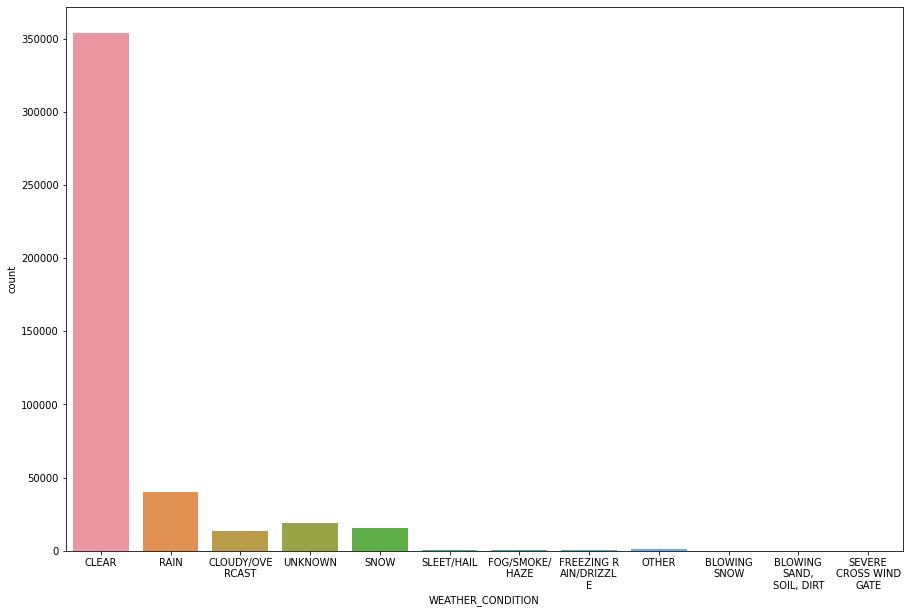

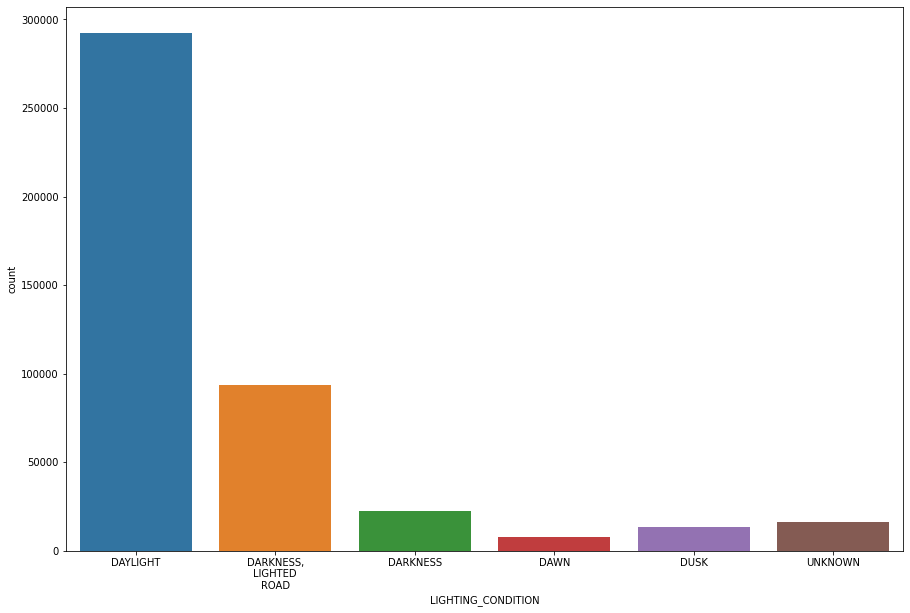

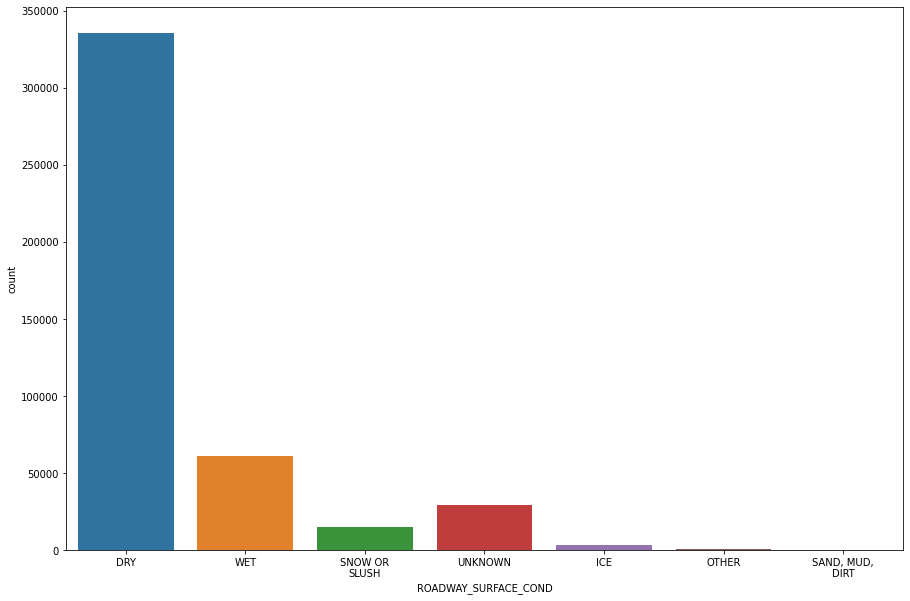

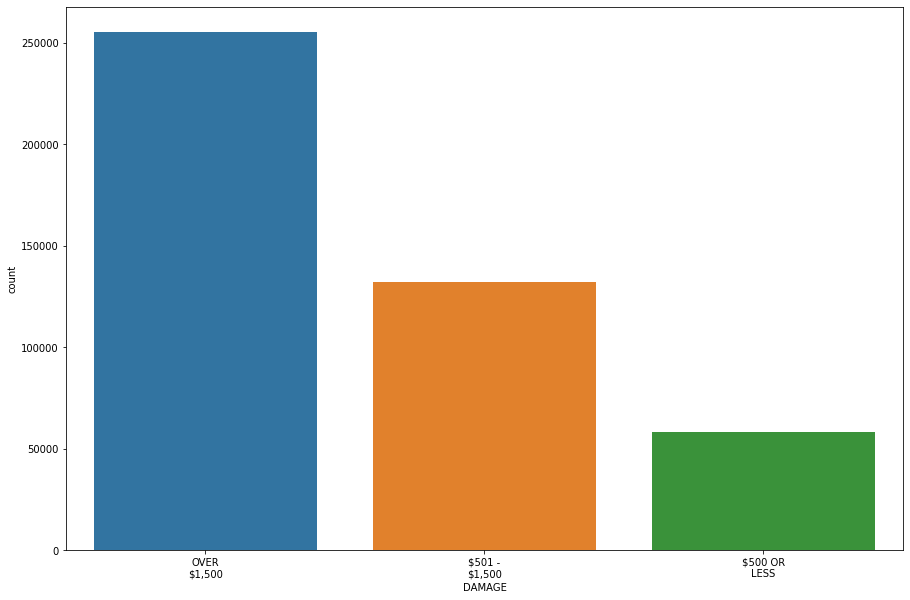

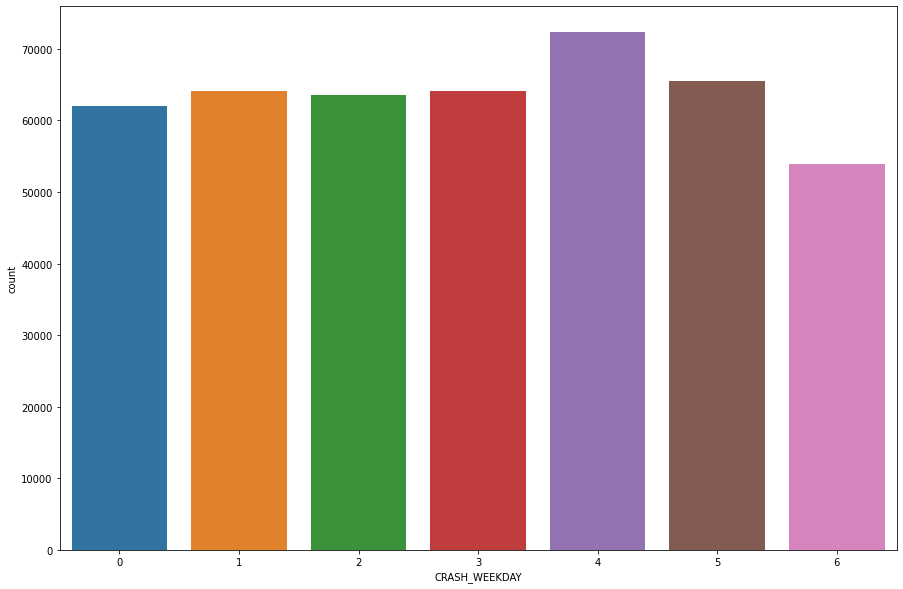

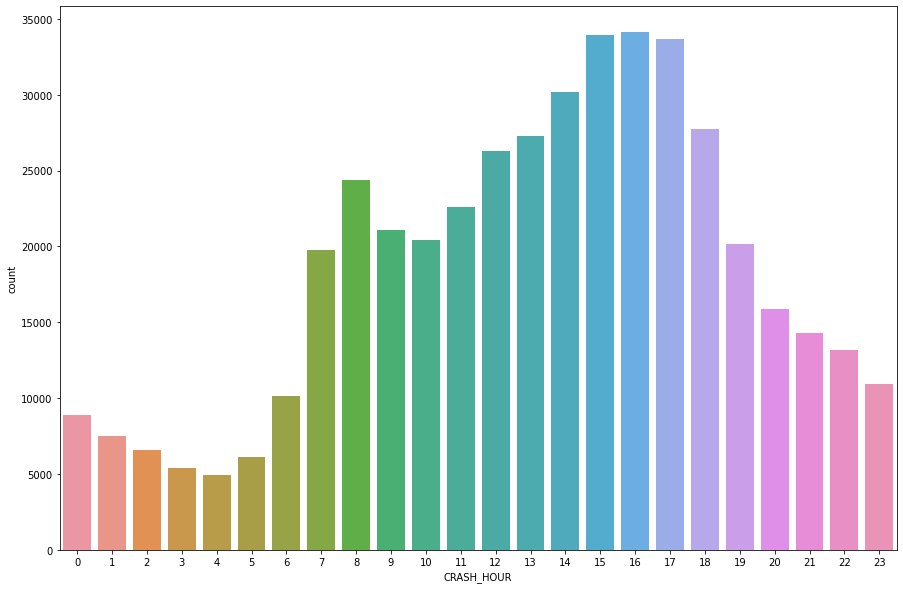

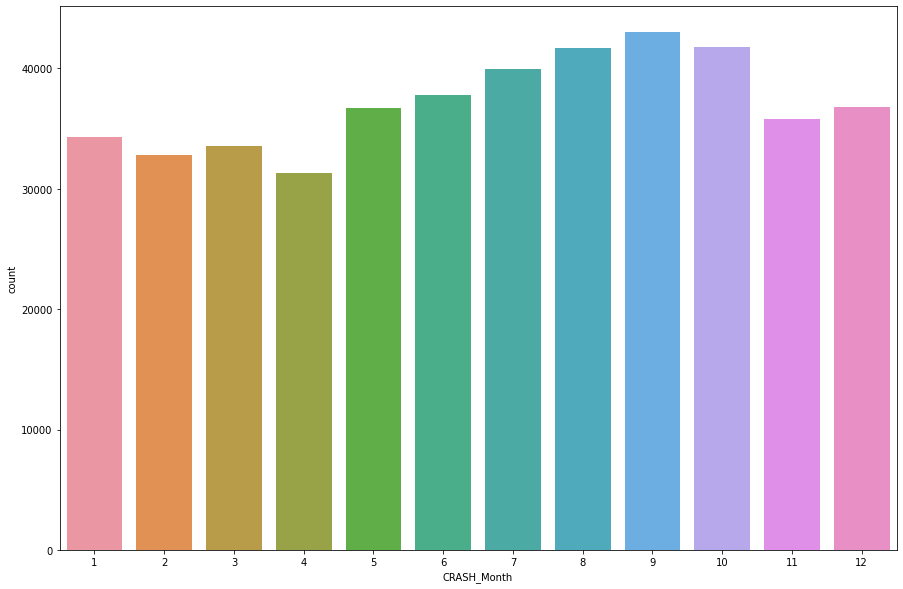

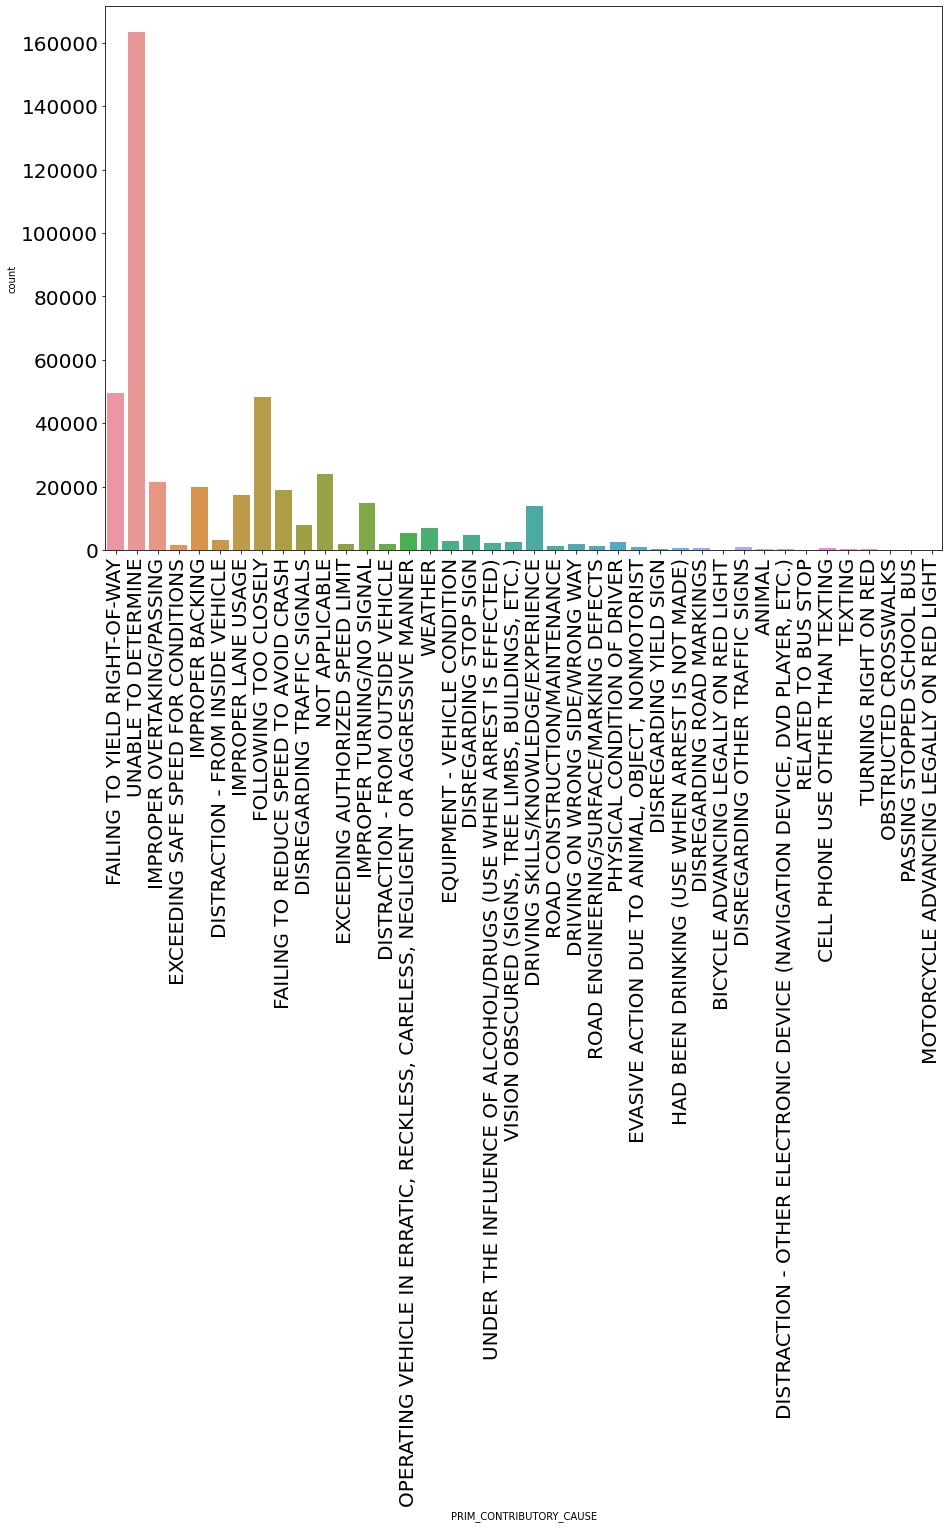

In [97]:
import textwrap
cols = ['WEATHER_CONDITION', 'LIGHTING_CONDITION',\
        'ROADWAY_SURFACE_COND', 'DAMAGE',\
       'CRASH_WEEKDAY', 'CRASH_HOUR', 'CRASH_Month']

max_width = 10

for i, col in enumerate(data[cols]):
    plt.figure(i, figsize = (15.0,10.0))
    b = sns.countplot(x=col, data=data)
    b.tick_params(labelsize=10)
    b.set_xticklabels(textwrap.fill(x.get_text(), max_width) for x in b.get_xticklabels())

plt.figure(10, figsize = (15.0,10.0))
b = sns.countplot(x=data['PRIM_CONTRIBUTORY_CAUSE'], data=data)
b.tick_params(labelsize=20)
b.set_xticklabels(b.get_xticklabels(), rotation = 90)

print("")

In [94]:
#removing conditions like 'unkown' and those which do not occur in large number
data_vis=data
data_vis = data_vis.loc[data_vis['WEATHER_CONDITION']\
                        .isin(['CLEAR', 'RAIN', 'CLOUDY/OVERCAST', 'SNOW'])]
data_vis = data_vis.loc[~data_vis['LIGHTING_CONDITION']\
                        .isin(['UNKNOWN'])]
data_vis = data_vis.loc[data_vis['ROADWAY_SURFACE_COND']\
                        .isin(['DRY', 'WET', 'SNOW OR SLUSH'])]
data_vis = data_vis.loc[data_vis['PRIM_CONTRIBUTORY_CAUSE']\
                        .isin(['FAILING TO YIELD RIGHT-OF-WAY',\
                               'IMPROPER OVERTAKING/PASSING',\
                              'IMPROPER BACKING', \
                              'IMPROPER LANE USAGE',\
                              'FOLLOWING TO CLOSELY',\
                              'FAILING TO REDUCE SPEED TO AVOID CRASH',\
                              'IMPROPER TURNING/NO SIGNAL',\
                              'DRIVING SKILLS/KONWLEDGE/EXPERIENCE'])]


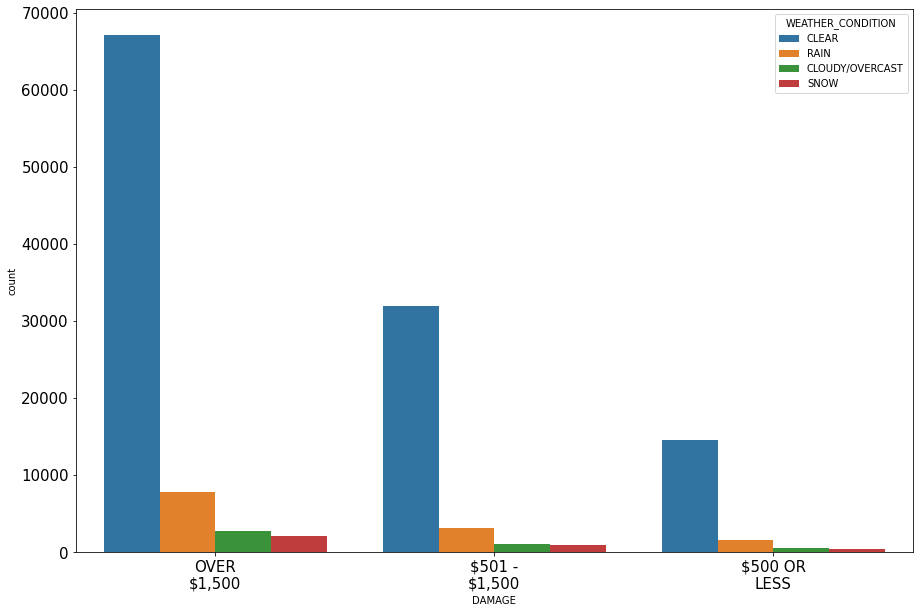

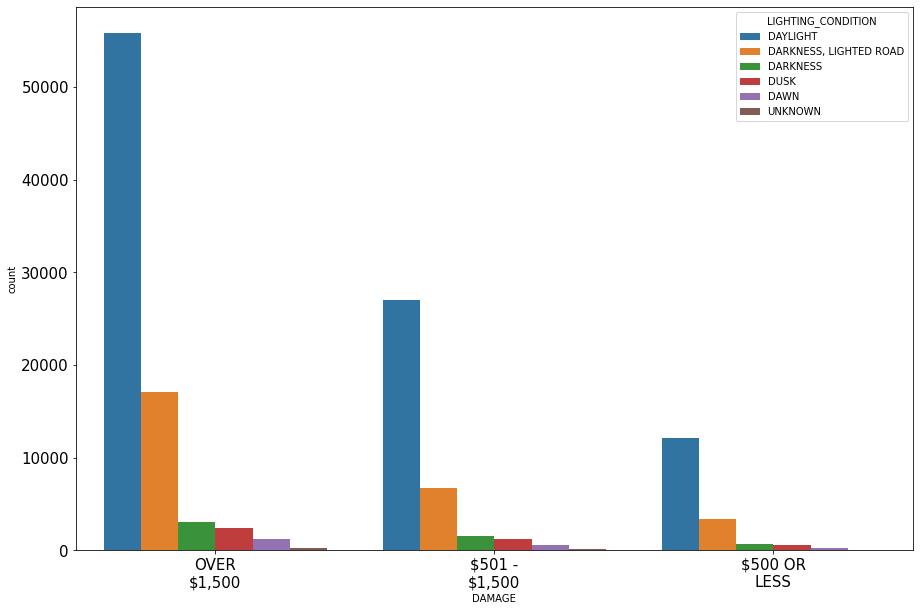

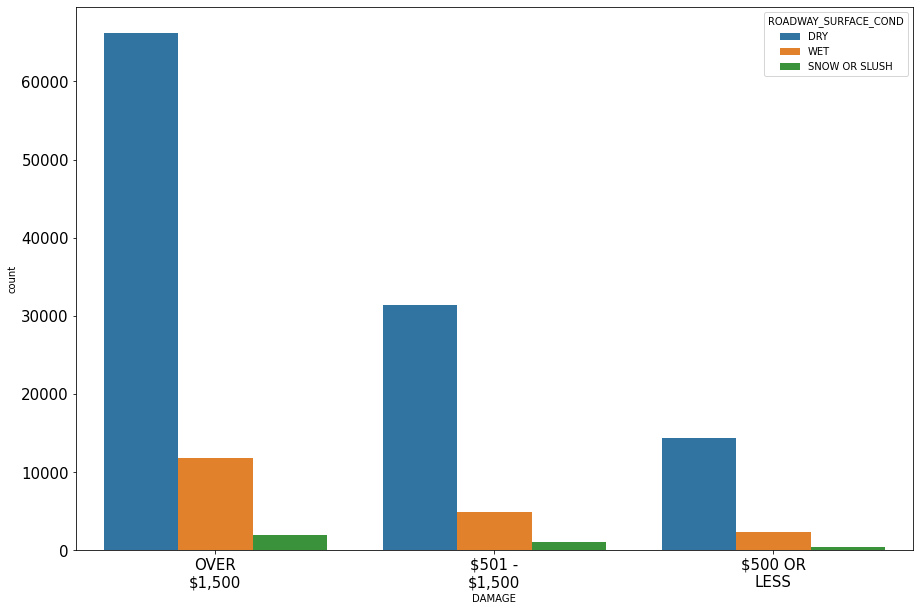

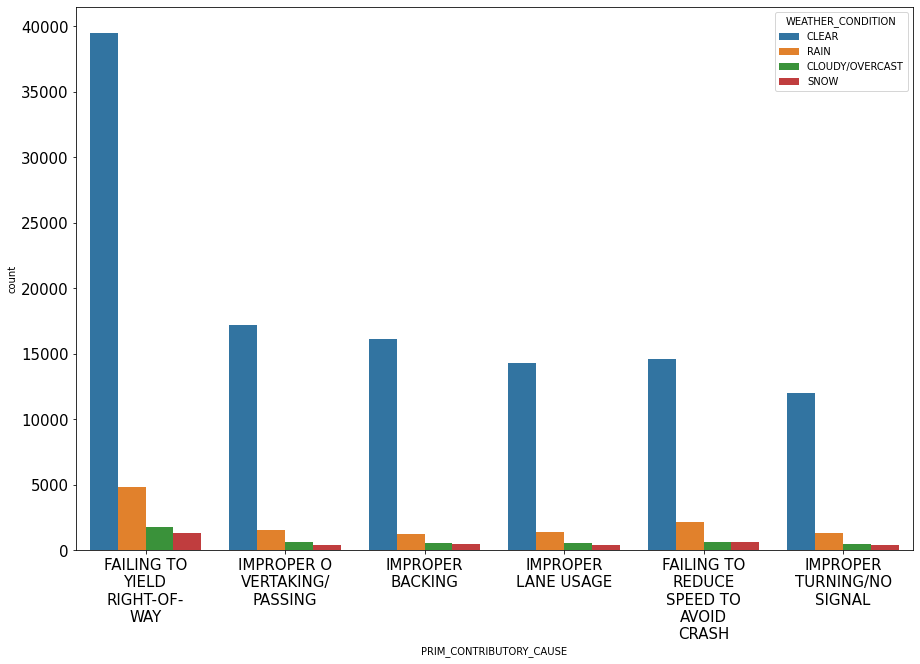

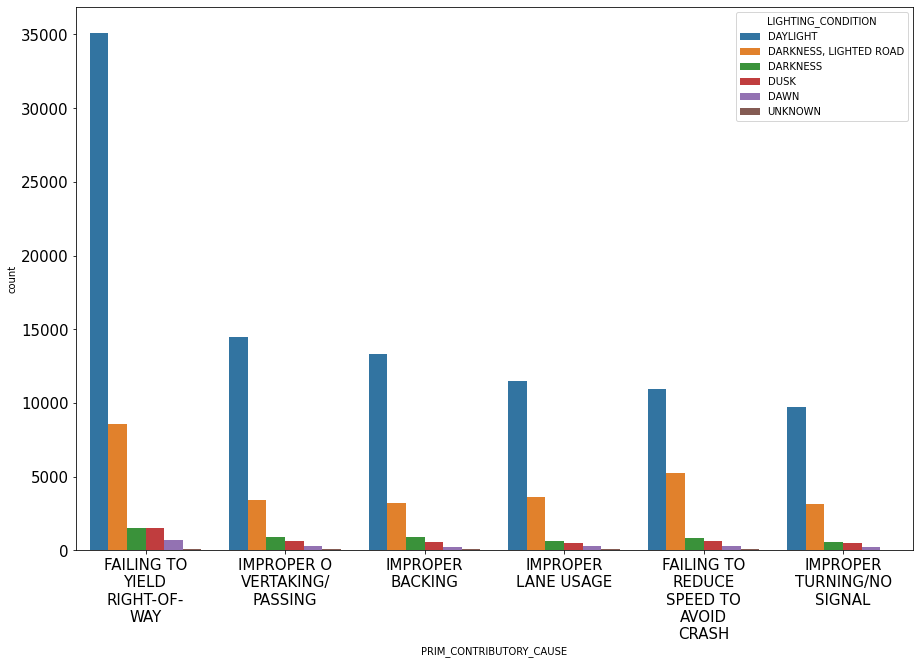

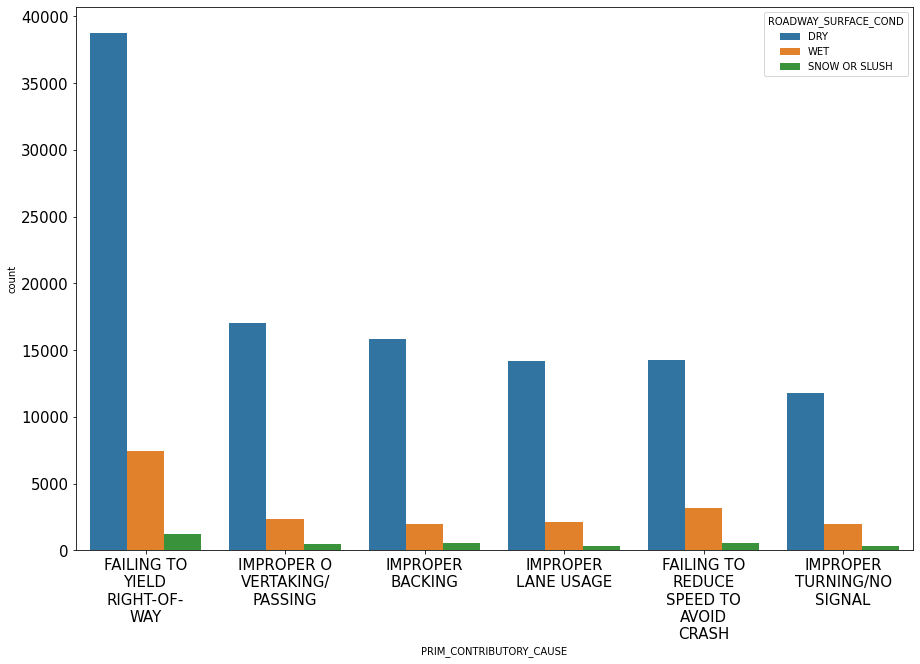

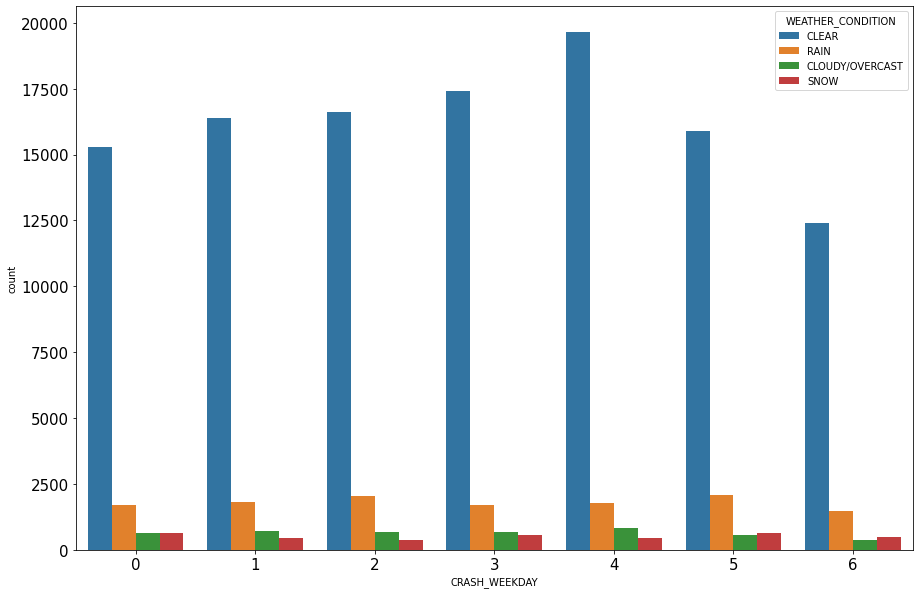

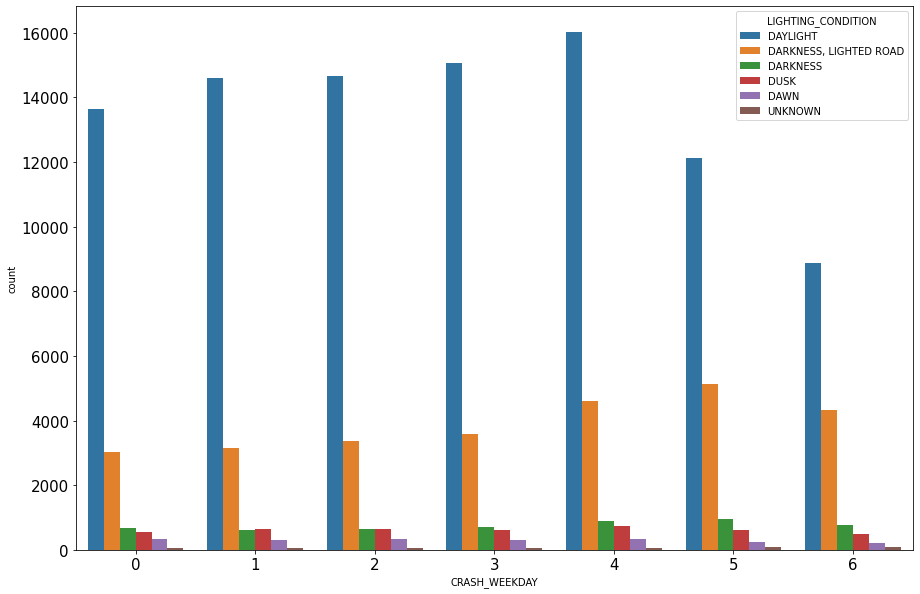

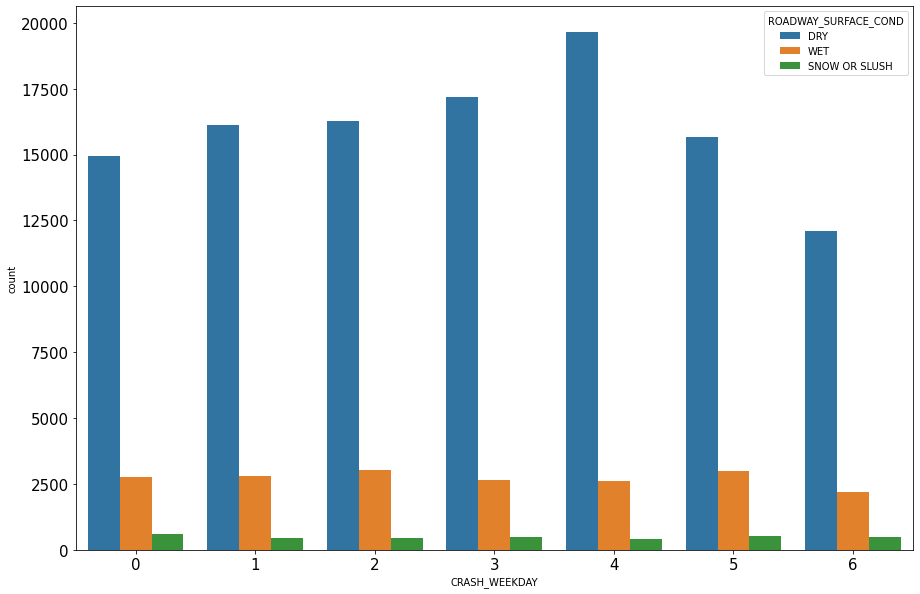

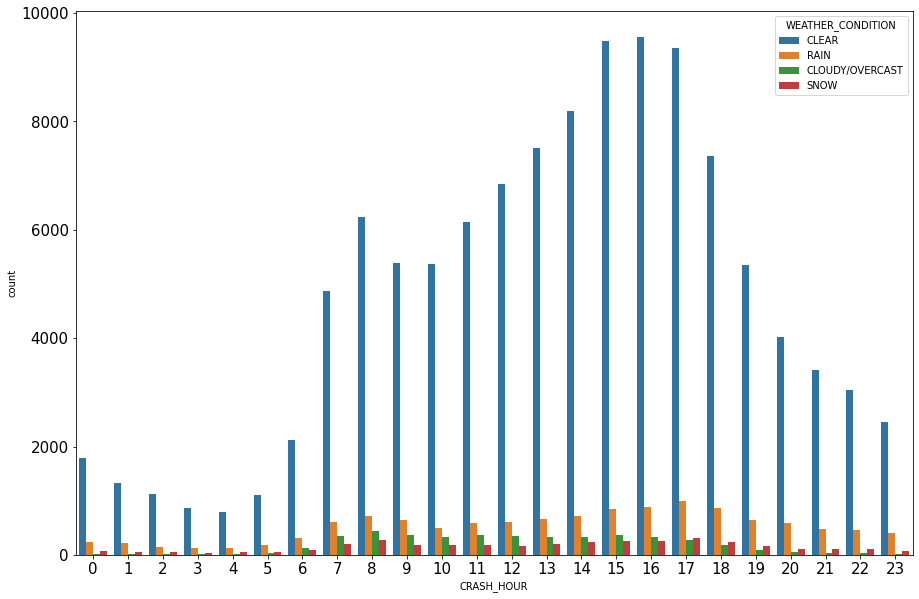

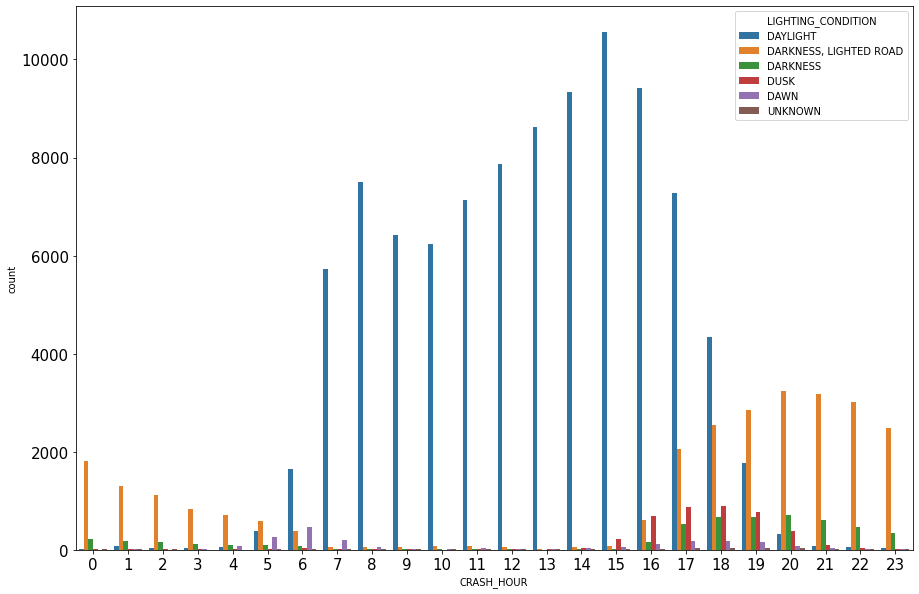

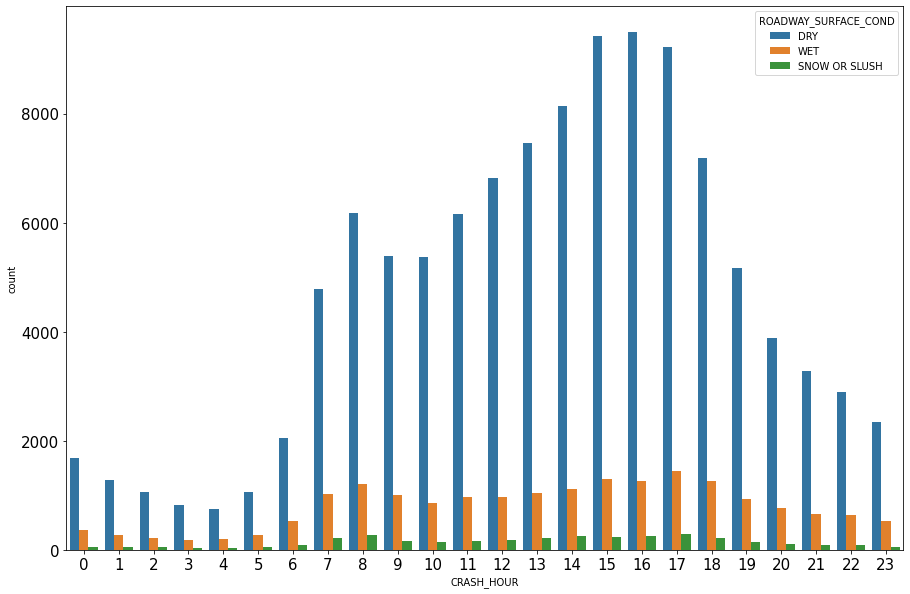

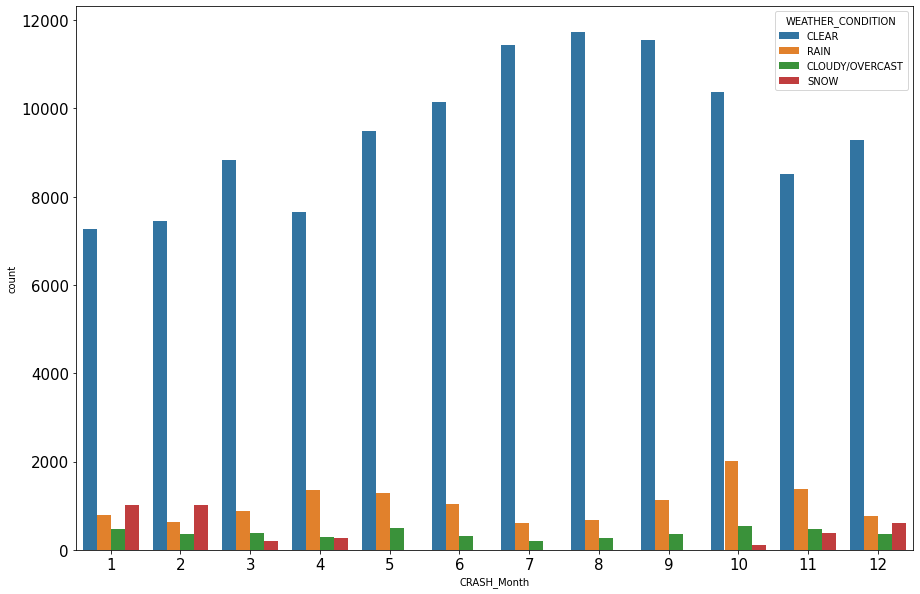

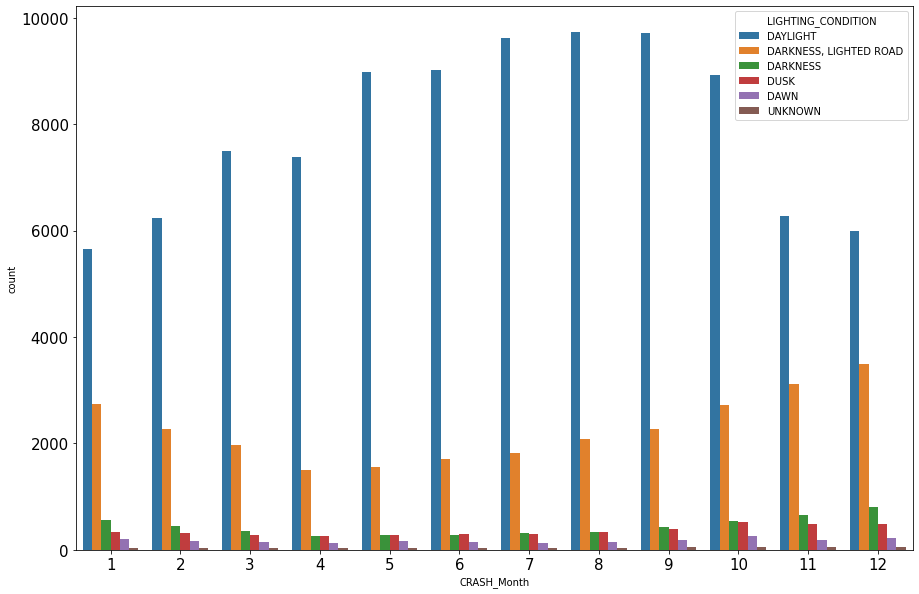

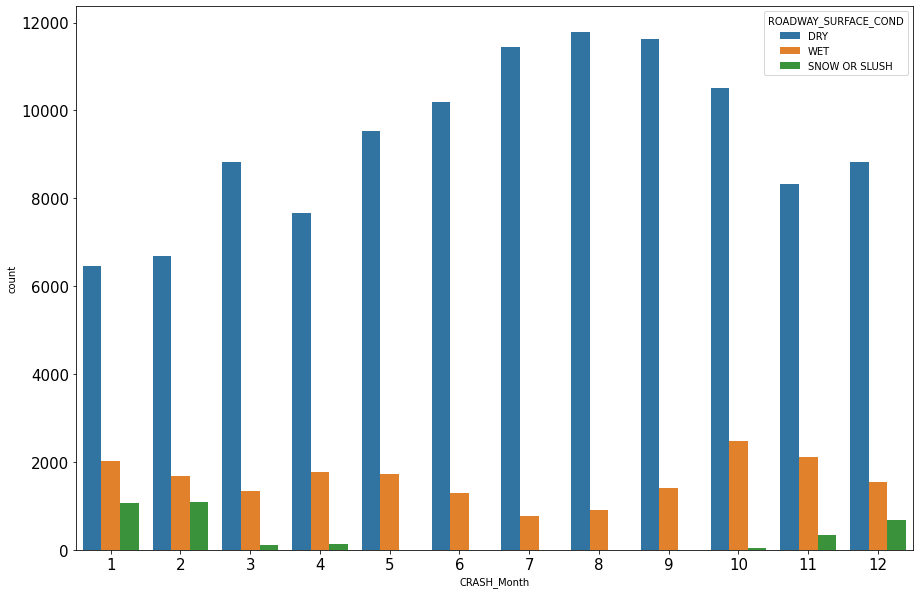

In [96]:
cols = ['DAMAGE', 'PRIM_CONTRIBUTORY_CAUSE',\
       'CRASH_WEEKDAY', 'CRASH_HOUR', 'CRASH_Month']

hues = ['WEATHER_CONDITION', 'LIGHTING_CONDITION',\
        'ROADWAY_SURFACE_COND']

max_width = 10

i=0
for col in data_vis[cols]:
    for hue in data_vis[hues]:
        plt.figure(i, figsize=(15.0,10.0))
        b = sns.countplot(x=col, hue=hue, data=data_vis)
        b.tick_params(labelsize=15)
        b.set_xticklabels(textwrap.fill(x.get_text(), max_width) for x in b.get_xticklabels())
        i+=1


#### Analysis
No abnormalities when combining external conditions with other variables. Major percentage of accidents happen in 'perfect conditions' meaning in clear weather, dry road and daylight. That leads to the conclusion that external factors play a minor role and human behaviour is by far the main factor. -> humans are stupid

?: are there differences of these conditions per cell? So in one cell many accidents at night happen etc...

Maybe: focus only on accidents which happen at not ideal conditions.